# MICCoM School 2022 Ex#1 : The vertical ionization potential of SiH<sub>4</sub>

We are going to compute the vertical ionization potential (VIP) of the silane molecule using two levels of theory, namely density functional theory (DFT) with the semilocal exchange-correlation functional PBE, and full-frequency G$_0$W$_0$.

The VIP is the minimum amount of energy that is needed to remove an electron from a molecule. When the removal does not take into account ion relaxation processes (change of molecular geometry), the ionization is said to be *vertical*.

The experimental value for the VIP of silane is tabulated in the NIST chemistry webbook: http://webbook.nist.gov/chemistry/form-ser/.

<p><center><b>VIP of silane = </b>$12.3$ eV <b>(experimental value)</b></center></p>

~ *We would like to compute the VIP of silane from first principles using DFT and GW.* ~

Let's see which level of theory performs better.

## 1.1 : DFT calculation

We are going to numerically solve the Kohn-Sham equations for *valence electrons* only. Electronic wavefunctions and single-particle energies are obtained by solving the secular equation:

\begin{equation}
H^{\text{KS}}[\rho] \, \psi_n = \varepsilon_n^{\text{KS}} \psi_n
\end{equation}

The Kohn-Sham Hamiltonian of $N$ interacting electrons includes the following terms:

\begin{equation}
H^{\text{KS}}[\rho] = T + V_{\text{ion}} + V_{\text{Hartree}}[\rho] + V_{\text{xc}}[\rho]
\end{equation}

where $T$ is the kinetic energy, $V_{\text{ion}}$ is the electron-ion potential, $V_{\text{Hartree}}$ is the Hartree potential, and $V_{\text{xc}}$ is the exchange-correlation potential.

Note that the secular equation needs to be solved *self-consistenly* since the operator that we are diagonalizing depends on the eigenvectors ($\rho = \sum_n |\psi_n|^2$).

We are going to use plane-waves as basis set, which means that an electronic wavefunction $\psi_n$ is obtained by computing the coefficients $C_n$ of the plane-waves expansion:

\begin{equation}
\psi_n(\mathbf{r}) = \sum_{\mathbf{G}} C_n(\mathbf{G}) e^{i\mathbf{G}\cdot\mathbf{r}}
\end{equation}

In this way the kinetic energy of a wavefunction is $\sum_{\mathbf{G}} \left| C_n(\mathbf{G}) \right|^2 \mathbf{G}^2$. The total number of plane-waves is determined once we specify the size of the simulation box and the kinetic energy cutoff.

The electron-ion potetial $V_{\text{ion}}$ is solved separately for each given atomic species. Pseudopotential files containing this information (previously computed) are typically loaded at the beginning of the calculation. Pseudopotentials can be downloaded from several websites, for instance:

- SG15 : http://www.quantum-simulation.org/potentials/sg15_oncv/
- Quantum ESPRESSO : https://www.quantum-espresso.org/pseudopotentials/

In this tutorial we will be using only norm-conserving pseudopotentials, i.e., no ultrasoft or projector augmented wave (PAW).

The Hartree potential is determined self-consistely as $V_{\text{Hartree}}(\mathbf{r}) = \int d\mathbf{r^\prime} \rho(\mathbf{r^\prime}) \frac{1}{|\mathbf{r}-\mathbf{r^\prime}|}$.

The exact form for the exchange and correlation potential is unknown. Many approximations are available. The user needs to make this decision. In this tutorial we will be using the PBE exchange-correlation functional, which belongs to the family of semilocal generalized gradient approximation (GGA).

If we interpret $\varepsilon^{\text{KS}}_n$ as electronic excitation energies (which is physically incorrect but people still do this as an approximation), the VIP will simply be the energy of the highest occupied molecular orbital (HOMO) obtained in a DFT calculation.

\begin{equation}
\text{VIP}^{\text{DFT}} = 0 - \varepsilon^{\text{KS}}_{\text{HOMO}}
\end{equation}

**Question**: *Where did the core electrons go?*

**Question**: *How many valence electrons do we have in SiH<sub>4</sub>?*

**Question**: *Plane-waves satisfy periodic boundary conditions, how can we simulate an isolated molecule?*

The following files are needed in order to compute the electronic structure of SiH$_4$ with DFT:

- `Si_ONCV_PBE-1.2.upf` : pseudopotential file for Si
- `H_ONCV_PBE-1.2.upf` : pseudopotential file for H
- `pw.in` : input file for the DFT calculation (executable `pw.x`)

In [1]:
# download the pseudopotential files
!wget -N -q http://www.quantum-simulation.org/potentials/sg15_oncv/upf/Si_ONCV_PBE-1.2.upf
!wget -N -q http://www.quantum-simulation.org/potentials/sg15_oncv/upf/H_ONCV_PBE-1.2.upf

# download the input file
!wget -N -q http://www.west-code.org/doc/training/silane/pw.in

Let's give a quick look at the input for DFT (description of the input variables for `pw.x` can be found here: https://www.quantum-espresso.org/Doc/INPUT_PW.html).

In [2]:
!cat pw.in

&control
calculation  = 'scf'
restart_mode = 'from_scratch'
pseudo_dir   = './'
outdir       = './'
prefix       = 'silane'
wf_collect   = .TRUE.
/
&system
ibrav           = 1
celldm(1)       = 20
nat             = 5
ntyp            = 2
ecutwfc         = 25.0
nbnd            = 10
assume_isolated ='mp'
/
&electrons
diago_full_acc = .TRUE.
/
ATOMIC_SPECIES
Si 28.0855  Si_ONCV_PBE-1.2.upf
H  1.00794   H_ONCV_PBE-1.2.upf
ATOMIC_POSITIONS bohr
Si      10.000000   10.000000  10.000000
H       11.614581   11.614581  11.614581
H        8.385418    8.385418  11.614581
H        8.385418   11.614581   8.385418
H       11.614581    8.385418   8.385418
K_POINTS {gamma}


We have placed the silane molecule in a cubic box (edge = 20 bohr), and specified a kinetic energy cutoff of 25 Ry.

We can run the DFT calculation invoking the executable `pw.x` on 4 cores. This calculation should finish in just a few seconds.

In [3]:
!mpirun -n 4 pw.x -i pw.in > pw.out

Let's extract the energy levels of the highest occupied molecular orbital (HOMO) and lowest unoccupied molecular orbital (LUMO) predicted by DFT.

In [4]:
!grep 'highest occupied, lowest unoccupied level' pw.out

     highest occupied, lowest unoccupied level (ev):    -8.2251   -0.4647


- HOMO : $-8.2251$ eV
- LUMO : $-0.4647$ eV

Let's plot this result.

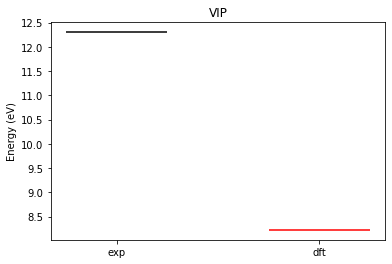

In [5]:
import matplotlib.pyplot as plt

# VIP
y = {}
y['exp'] = [12.3]     # experimental
y['dft'] = [8.2251]   # DFT

# colors of the plot
c = {}
c['exp'] = 'black'
c['dft'] = 'red'

# plot
x = list(range(1, len(y)+1))
labels = y.keys()

fig, ax = plt.subplots(1, 1)
for counter, label in enumerate(labels) :
    for a in y[label] :
        ax.hlines(a, x[counter]-0.25, x[counter]+0.25, color=c[label])

plt.xticks(x, labels)
plt.ylabel('Energy (eV)')
plt.title('VIP')

plt.show()

**Question**: *Is this level of agreement ok?*

## 1.2 : Full-frequency G<sub>0</sub>W<sub>0</sub> calculation

The GW method in the framework of many-body perturbation theory (MBPT) can improve the result of DFT by computing single-particle excitations as the eigenvalues of the quasiparticle (QP) Hamiltonian:

\begin{equation}
H^{\text{QP}}[\rho] = T + V_{\text{ion}} + V_{\text{Hartree}}[\rho] + \Sigma
\end{equation}

Note that $H^{\text{QP}}$ can be obtained from $H^{\text{KS}}$ by replacing the exchange and correlation potential with the self-energy $\Sigma$. In the GW approximation the electron self-energy can be written as :

\begin{equation}
\Sigma(\mathbf{r},\mathbf{r^\prime};E)  = i \int \frac{d\omega}{2\pi} G(\mathbf{r},\mathbf{r^\prime};E-\omega) W(\mathbf{r},\mathbf{r^\prime};\omega)
\end{equation}

$G$ is the Green's function and $W=\epsilon^{-1}v$ is the screened Coulomb potential. Because both $G$ and $W$ depend self-consistently on the solution of the QP Hamiltonian, typically the eigenvalues of the operator of $H^{\text{QP}}$ are obtained using the eigenvalues and eigenvectors of $H^{\text{KS}}$ (computed previously in DFT) and using first order perturbation theory:

\begin{equation}
E^{\text{QP}}_n = \varepsilon^{\text{KS}}_n + \left\langle \psi_n \right | \Sigma(E^{\text{QP}}_n) - V_{\text{xc}}\left| \psi_n \right\rangle
\end{equation}

Following the workflow discussed in [J. Chem. Theory Comput. 11, 2680 (2015)](https://pubs.acs.org/doi/full/10.1021/ct500958p#showFigures), we use the DFT output to:

- Compute the dielectric screening : executable `wstat.x`
- Compute the quasiparticle energies : executable `wfreq.x`

<img src="https://pubs.acs.org/cms/10.1021/ct500958p/asset/images/large/ct-2014-00958p_0002.jpeg" width="50%">

## 1.2.1 : Calculation of dielectric screening

The `wstat` executable will read the output of DFT and will compute the static dielectric screening adopting the projective dielectric eigendecomposition (PDEP) technique. An iterative diagonalization of the dielectric matrix is performed:

\begin{equation}
\epsilon_{\mathbf{G},\mathbf{G^\prime}}(\omega=0) = \sum_{i=1}^{\texttt{n_pdep_eigen}} \, \phi_i(\mathbf{G}) \, \lambda_i \phi^\ast_i(\mathbf{G^\prime})
\end{equation}

where $\phi_i$ and $\lambda_i$ are the eigenvectors and eigenvalues of the dielectric matrix (extressed here in terms of plane-waves). The eigenvectors $\phi_i$ are used as the basis set for the subsequent GW calculation.

The diagonalization is started with random potentials and then iterated using the Davidson algorithm:

<img src="https://pubs.acs.org/cms/10.1021/ct500958p/asset/images/large/ct-2014-00958p_0003.jpeg" width="60%">

Let's download and give a quick look at the input for `wstat.x` (description of the input variables for `wstat.x` can be found here: http://www.west-code.org/doc/West/latest/manual.html#wstat-control).

In [6]:
!wget -N -q http://www.west-code.org/doc/training/silane/wstat.in
!cat wstat.in

input_west:
    qe_prefix: silane
    west_prefix: silane
    outdir: ./

wstat_control:
    wstat_calculation: S
    n_pdep_eigen: 50

The variable `silane` instructs the code to find the output of DFT in the folder `silane.save`. We are computing 50 eigenpotentials $\phi_i$, i.e., 50 eigenvectors of the static dielectric matrix. This step uses the *occupied* single-particle states and energies obtained in the DFT calculation. **Unoccupied states are not needed**.

We can run the PDEP calculation invoking the executable `wstat.x` on 16 cores. This calculation should finish in 1 minute.

In [7]:
!mpirun -n 16 wstat.x -i wstat.in > wstat.out

We load the output (in JSON format) of the `wstat.x` calculation, which can be found in the `silane.wstat.save` folder.

In [8]:
import json

# read data from JSON file
with open('silane.wstat.save/wstat.json', 'r') as file :
    data = json.load(file)

# print the data
print(json.dumps(data, indent=2))

{
  "runjob": {
    "startdate": "11Oct2022",
    "starttime": " 9:32:59",
    "completed": true,
    "endtime": " 9:33:15",
    "enddate": "11Oct2022"
  },
  "software": {
    "package": "WEST",
    "program": "WSTAT",
    "version": "5.2.0",
    "westgit": "v5.2.0-10-g918d532",
    "website": "http://www.west-code.org",
    "citation": "M. Govoni et al., J. Chem. Theory Comput. 11, 2680 (2015).",
    "qeversion": "7.1"
  },
  "config": {
    "io": {
      "islittleendian": true
    }
  },
  "parallel": {
    "nranks": 16,
    "nimage": 1,
    "npool": 1,
    "nbgrp": 1,
    "nrg": 16,
    "nproc": 16,
    "nthreads": 1
  },
  "input": {
    "input_west": {
      "qe_prefix": "silane",
      "west_prefix": "silane",
      "outdir": "./"
    },
    "wstat_control": {
      "wstat_calculation": "S",
      "n_pdep_eigen": 50,
      "n_pdep_times": 4,
      "n_pdep_maxiter": 100,
      "n_dfpt_maxiter": 250,
      "n_pdep_read_from_file": 0,
      "n_steps_write_restart": 1,
      "trev_p

Now we can plot the 50 eigenvalues $\lambda_i$ of the dielectric matrix.

y :  [-1.2754720668029091, -1.1919988897734295, -1.191991425327886, -1.1918750479082716, -0.8244331954209921, -0.8243719902168194, -0.8243070584764758, -0.6363480751501617, -0.6296638864684181, -0.62965468160695, -0.5007531991331637, -0.5007192212407726, -0.5006633284291045, -0.4301010610680996, -0.4300878999594423, -0.43006394104361023, -0.2324590857953143, -0.23245478344153164, -0.2324498222228378, -0.18328843644430254, -0.18325666138108107, -0.1832473382383492, -0.1784332377577128, -0.1775504004743457, -0.17754325566955023, -0.14596095608969584, -0.14595895912881743, -0.1459466107908167, -0.12261797473339454, -0.12014634880115369, -0.12014593756057011, -0.12014040871072855, -0.11637378892529171, -0.11636989698973867, -0.11531375801416825, -0.11530875850124506, -0.11530541512826781, -0.09409890231649157, -0.09409787245061647, -0.0940955088831779, -0.07996894456596207, -0.07996593163736887, -0.07996545801532576, -0.07480835355986729, -0.07311589574225359, -0.07311484170817655, -0.0657

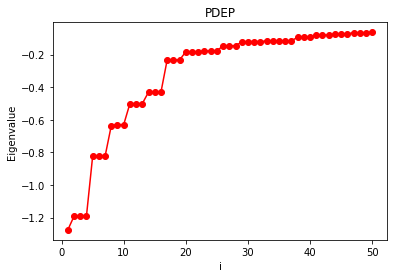

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# y : eigenvalues of the dielectic matrix
y = data['exec']['davitr'][-1]['ev']
# x : index of eigenvalue
x = np.arange(1, len(y)+1, 1)

print('y : ', y)
print('x : ', x)

# plot
fig, ax = plt.subplots(1, 1)
ax.plot(x, y, 'ro-')

plt.xlabel('i')
plt.ylabel('Eigenvalue')
plt.title('PDEP')

plt.show()

As we can see, the eigenvalues of the dielectric matrix decay to zero. The number of PDEPs, `n_pdep_eigen`, controls the size of the basis set used in the GW calculation. `n_pdep_eigen` is a parameter of the simulation that needs to be converged. Typically, `n_pdep_eigen` is set to multiple of the number of electrons in the system.

**Question**: *How do we compute 70 eigenpotentials?*

## 1.2.2 : Calculation of GW electronic structure

The GW electronic structure is computed by computing the dielectric screening at multipole frequencies with Lanczos iterations and by treating the frequency integration of the correlation part of the self energy with the contour deformation techinique.

Let's download and give a quick look at the input for `wfreq.x` (description of the input variables for `wfreq.x` can be found here: http://www.west-code.org/doc/West/latest/manual.html#wfreq-control).

In [10]:
!wget -N -q http://www.west-code.org/doc/training/silane/wfreq.in
!cat wfreq.in

input_west:
    qe_prefix: silane
    west_prefix: silane
    outdir: ./

wstat_control:
    wstat_calculation: S
    n_pdep_eigen: 50

wfreq_control:
    wfreq_calculation: XWGQ
    n_pdep_eigen_to_use: 50
    qp_bandrange: [1,5]
    n_refreq: 300
    ecut_refreq: 2.0

The keyword `XWGQ` instructs the code to compute the exact exchange operator (`X`), the screened Coulomb operator (`W`), the Green's function (`G`), and the quasiparticle energies (`Q`).

In this case we are using the 50 eigenpotentials $\phi_i$ obtained by `wstat.x`.

We are going to compute the quasiparticle energies of the states 1, 2, 3, 4 (HOMO), and 5 (LUMO). Remember that in this example (spin-unpolarized) each state can host two electrons.

The frequency parameters control the contour deformation integration. The frequency dependence of the dielectric screening is sampled in the energy window $[0,2]$ Ry using 300 points.

We can run the GW calculation invoking the executable `wfreq.x` on 16 cores. This calculation should finish in 1 minute.

In [11]:
!mpirun -n 16 wfreq.x -i wfreq.in > wfreq.out

We load the output (in JSON format) of the `wfreq.x` calculation, which can be found in the `silane.wfreq.save` folder.

In [12]:
import json

# read data from JSON file
with open('silane.wfreq.save/wfreq.json', 'r') as file :
    data = json.load(file)

# print the data
print(json.dumps(data, indent=2))

{
  "runjob": {
    "startdate": "11Oct2022",
    "starttime": " 9:33:34",
    "completed": true,
    "endtime": " 9:33:43",
    "enddate": "11Oct2022"
  },
  "software": {
    "package": "WEST",
    "program": "WFREQ",
    "version": "5.2.0",
    "westgit": "v5.2.0-10-g918d532",
    "website": "http://www.west-code.org",
    "citation": "M. Govoni et al., J. Chem. Theory Comput. 11, 2680 (2015).",
    "qeversion": "7.1"
  },
  "config": {
    "io": {
      "islittleendian": true
    }
  },
  "parallel": {
    "nranks": 16,
    "nimage": 1,
    "npool": 1,
    "nbgrp": 1,
    "nrg": 16,
    "nproc": 16,
    "nthreads": 1
  },
  "input": {
    "input_west": {
      "qe_prefix": "silane",
      "west_prefix": "silane",
      "outdir": "./"
    },
    "wstat_control": {
      "wstat_calculation": "S",
      "n_pdep_eigen": 50,
      "n_pdep_times": 4,
      "n_pdep_maxiter": 100,
      "n_dfpt_maxiter": 250,
      "n_pdep_read_from_file": 0,
      "n_steps_write_restart": 1,
      "trev_p

We can print the quasiparticle energy levels using the [WESTpy Python package](http://www.west-code.org/doc/westpy/latest/), which offers useful pre- and post-processing tools for WEST calculations.

In [13]:
from westpy import wfreq2df

df, data = wfreq2df('silane.wfreq.save/wfreq.json')
display(df)

 
 _    _ _____ _____ _____            
| |  | |  ___/  ___|_   _|           
| |  | | |__ \ `--.  | |_ __  _   _  
| |/\| |  __| `--. \ | | '_ \| | | | 
\  /\  / |___/\__/ / | | |_) | |_| | 
 \/  \/\____/\____/  \_/ .__/ \__, | 
                       | |     __/ | 
                       |_|    |___/  
 
WEST version     :  5.2.0
Today            :  2022-10-11 09:34:04.514495


,k,s,n,eks,eqpLin,eqpSec,sigmax,sigmac_eks,sigmac_eqpLin,sigmac_eqpSec,vxcl,vxcnl,hf
0,1,1,1,-13.230981,-16.266152,-16.126443,-17.605224,1.765983,3.581008,3.440954,-11.249025,0.0,-6.356199
1,1,1,2,-8.226552,-12.145990,-12.041376,-15.765070,0.010467,0.730523,0.707375,-11.242267,0.0,-4.522804
2,1,1,3,-8.225378,-12.141824,-12.037079,-15.764311,0.013781,0.733381,0.710218,-11.241788,0.0,-4.522522
3,1,1,4,-8.225073,-12.141850,-12.037102,-15.764136,0.013238,0.732984,0.709818,-11.241686,0.0,-4.522450
4,1,1,5,-0.464670,0.664173,0.663068,-0.585458,-0.348132,-0.371835,-0.371811,-2.085008,0.0,1.499550


All energies in the table are given in eV. The full-frequency G$_0$W$_0$ energies correspond to the `eqpSec` column.

Full explanation of the keys:

- `k` : k-point index
- `s` : spin index
- `n` : state index
- `eks` : Kohn-Sham energy $\varepsilon^{\text{KS}}_n$, obtained in the DFT calculation
- `eqpLin` : quasiparticle energy $E^{\text{QP}}_n$, obtained by approximating the self-energy to first order in the frequency
- `eqpSec` : quasiparticle energy $E^{\text{QP}}_n$, obtained by using the secant method to solve the frequency-dependency in the quasiparticle equation
- `sigmax` : exchange self-energy
- `sigmac_eks` : correlation self-energy, evaluated at `eks` (`re` and `im` identify the real and imaginary parts respectively)
- `sigmac_eqpLin` : correlation self-energy, evaluated at `eqpLin`
- `sigmac_eqpSec` : correlation self-energy, evaluated at `eqpSec`
- `vxcl` : contribution to the energy given by the semilocal exchange-correlation functional
- `vxcnl` : contribution to the energy given by the excact exchange (when using hybrid functional)
- `hf` : quasiparticle energy according to perturbative Hartree-Fock, i.e., no correlation self-energy

Let's use WESTpy to plot the density of states (DOS), obtained as a sum of Gaussian functions

\begin{equation}
\text{DOS}(E) = \sum_{i=1}^{N_{\text{states}}} \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{(E-E_i)^2}{2\sigma^2}}
\end{equation}

We use $\sigma$ = 0.2 eV.

Requested (emin,emax) :  -18.0 2.0
Detected  (emin,emax) :  -16.126442757174104 0.663067500001202
output written in :  dos.png
waiting for user to close image preview...


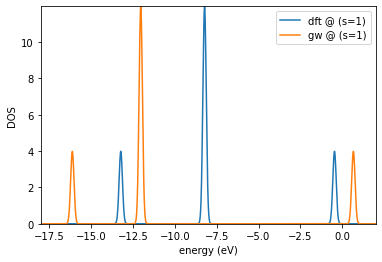

In [14]:
from westpy import ElectronicStructure

# extracting energy levels from the data
y = {}
y['dft'] = data['output']['Q']['K000001']['eks']
y['gw']  = data['output']['Q']['K000001']['eqpSec']

es = ElectronicStructure()

for key in ['dft','gw'] :
    es.addKey(key,key)
    for b, energy in enumerate(y[key]) :
        es.addDataPoint([1,1,b+1],key,y[key][b])

es.plotDOS(kk=[1],ss=[1],energyKeys=['dft','gw'],energyRange=[-18.,2.,0.01],fname='dos.png')

Now going back to the problem of computing the vertical ionization potential of SiH$_4$, in the GW case we have:

\begin{equation}
\text{VIP}^{\text{GW}} = 0 - E^{\text{QP}}_{\text{HOMO}}
\end{equation}

The HOMO (`n=4` in the table) predicted by GW is located at $-12.037102$ eV. Let's update the VIP plot to compare DFT and GW results.

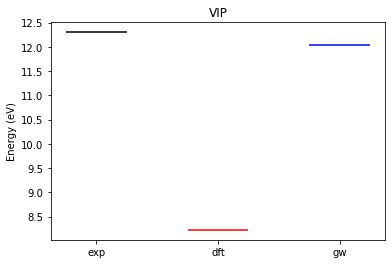

In [15]:
import matplotlib.pyplot as plt

# VIP
y = {}
y['exp'] = [12.3]      # experimental
y['dft'] = [8.2251]    # dft
y['gw']  = [12.037102] # gw

# colors
c = {}
c['exp'] = 'black'
c['dft'] = 'red'
c['gw']  = 'blue'

# plot
x = list(range(1, len(y)+1))
labels = y.keys()

fig, ax = plt.subplots(1, 1)
counter = 0
for counter, label in enumerate(labels) :
    for a in y[label] :
        ax.hlines(a, x[counter]-0.25, x[counter]+0.25, color=c[label])

plt.xticks(x, labels)
plt.ylabel('Energy (eV)')
plt.title('VIP')

plt.show()

If we take into account finite size effects, we have:

\begin{equation}
\text{VIP}^{\text{GW}} = E_{\text{vacuum}} - E^{\text{QP}}_{\text{HOMO}}
\end{equation}

We extract the vacuum energy from the output of the DFT calculation.

In [16]:
!grep 'Corrected vacuum level' pw.out

     Corrected vacuum level    =       0.24581357 eV


The vacuum energy is $0.24581357$ eV. Let's update the VIP plot again.

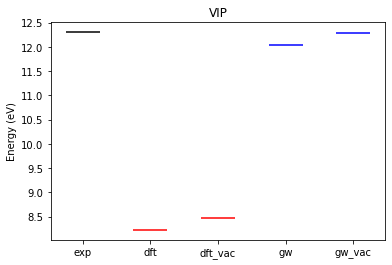

In [17]:
import matplotlib.pyplot as plt

# vacumm
vacuum = 0.24581357

# VIP
y = {}
y['exp']     = [12.3]             # experimental
y['dft']     = [8.2251]           # dft
y['dft_vac'] = [8.2251+vacuum]    # dft
y['gw']      = [12.037102]        # gw
y['gw_vac']  = [12.037102+vacuum] # gw

# colors
c = {}
c['exp']     = 'black'
c['dft']     = 'red'
c['dft_vac'] = 'red'
c['gw']      = 'blue'
c['gw_vac']  = 'blue'

# plot
x = list(range(1, len(y)+1))
labels = y.keys()

fig, ax = plt.subplots(1, 1)
for counter, label in enumerate(labels) :
    for a in y[label] :
        ax.hlines(a, x[counter]-0.25, x[counter]+0.25, color=c[label])

plt.xticks(x, labels)
plt.ylabel('Energy (eV)')
plt.title('VIP')

plt.show()

**Question**: *Which level of theory better describes electronic excitations, DFT or GW?*

Finally, we inspect the convergence of GW with respect to the size of the basis set used to represent the dielectric matrices. We have computed 50 eigenpotentials using `wstat.x`. We can now use *fewer* eigenpotentials in `wfreq.x` and test the convergece.

Let's prepare the input for 5 calculations done with 10, 20, 30, 40, 50 eigenpotentials. This is achieved by setting the `n_pdep_eigen_to_use` keyword in the input file.

In [18]:
import yaml

# create 5 files, each with a different value of the variable n_pdep_eigen_to_use
for npdep in [10, 20, 30, 40, 50] :

    # read data wfreq.in
    with open('wfreq.in', 'r') as file :
        input_data = yaml.load(file, Loader=yaml.FullLoader)

    # modify the input_data
    input_data['wfreq_control']['n_pdep_eigen_to_use'] = npdep

    # write data to YAML file
    with open(f'wfreq_{npdep}.in', 'w') as file :
        yaml.dump(input_data, file, sort_keys=False)

In [19]:
# give a quick look
!cat wfreq_10.in
!cat wfreq_20.in
!cat wfreq_30.in
!cat wfreq_40.in
!cat wfreq_50.in

input_west:
  qe_prefix: silane
  west_prefix: silane
  outdir: ./
wstat_control:
  wstat_calculation: S
  n_pdep_eigen: 50
wfreq_control:
  wfreq_calculation: XWGQ
  n_pdep_eigen_to_use: 10
  qp_bandrange:
  - 1
  - 5
  n_refreq: 300
  ecut_refreq: 2.0
input_west:
  qe_prefix: silane
  west_prefix: silane
  outdir: ./
wstat_control:
  wstat_calculation: S
  n_pdep_eigen: 50
wfreq_control:
  wfreq_calculation: XWGQ
  n_pdep_eigen_to_use: 20
  qp_bandrange:
  - 1
  - 5
  n_refreq: 300
  ecut_refreq: 2.0
input_west:
  qe_prefix: silane
  west_prefix: silane
  outdir: ./
wstat_control:
  wstat_calculation: S
  n_pdep_eigen: 50
wfreq_control:
  wfreq_calculation: XWGQ
  n_pdep_eigen_to_use: 30
  qp_bandrange:
  - 1
  - 5
  n_refreq: 300
  ecut_refreq: 2.0
input_west:
  qe_prefix: silane
  west_prefix: silane
  outdir: ./
wstat_control:
  wstat_calculation: S
  n_pdep_eigen: 50
wfreq_control:
  wfreq_calculation: XWGQ
  n_pdep_eigen_to_use: 40
  qp_bandrange:
  - 1
  - 5
  n_refreq: 300
  e

We run them all and stash the output files. These calculations should finish in 3 minutes.

In [20]:
!rm -f silane.wfreq.save/*.json

!mpirun -n 16 wfreq.x -i wfreq_10.in > wfreq_10.out
!mv silane.wfreq.save/wfreq.json wfreq_10.json

!mpirun -n 16 wfreq.x -i wfreq_20.in > wfreq_20.out
!mv silane.wfreq.save/wfreq.json wfreq_20.json

!mpirun -n 16 wfreq.x -i wfreq_30.in > wfreq_30.out
!mv silane.wfreq.save/wfreq.json wfreq_30.json

!mpirun -n 16 wfreq.x -i wfreq_40.in > wfreq_40.out
!mv silane.wfreq.save/wfreq.json wfreq_40.json

!mpirun -n 16 wfreq.x -i wfreq_50.in > wfreq_50.out
!mv silane.wfreq.save/wfreq.json wfreq_50.json

We plot the quasiparticle energy levels as a function of `n_pdep_eigen_to_use`.

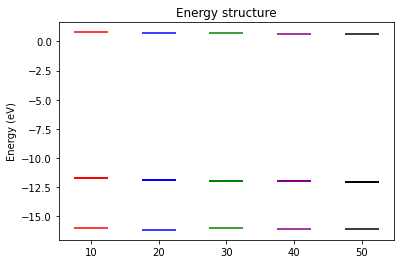

In [21]:
import json
import matplotlib.pyplot as plt

# load data from wfreq_XX.json
data = {}
for npdep in [10, 20, 30, 40, 50] :
    with open(f'wfreq_{npdep}.json') as file :
        data[npdep] = json.load(file)

# energy levels
y = {}
for npdep in [10, 20, 30, 40, 50] :
    y[npdep] = data[npdep]['output']['Q']['K000001']['eqpSec']

# colors
c = {}
c[10] = 'red'
c[20] = 'blue'
c[30] = 'green'
c[40] = 'purple'
c[50] = 'black'

# plot
x = list(range(1, len(y)+1))
labels = y.keys()

fig, ax = plt.subplots(1, 1)
for counter, label in enumerate(labels) :
    for a in y[label] :
        ax.hlines(a, x[counter]-0.25, x[counter]+0.25, color=c[label])

plt.xticks(x, labels)
plt.ylabel('Energy (eV)')
plt.title('Energy structure')

plt.show()

**Question**: *How many PDEPs are needed to converge the quasiparticle energies?*